In [1]:
import logging
logging.basicConfig(filename='manski-analysis.log', level=logging.INFO)

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/manski_bounds_bootstrap/'

In [3]:
col_name = 'Calcium'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [4]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [5]:
column_mappings = {
#     'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
#     'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
#     'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
#     'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
#     'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [6]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-train.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [7]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2][[
       'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR',
       'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
       'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
       'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
       'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
       'Arterial_BE', 'HCO3', 'Arterial_lactate']].reset_index()

MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[col_name]>0].reset_index()
MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index()

In [8]:
pulse_data_t0 = pulse_data[pulse_data['index']==1].reset_index(drop=True)
pulse_data_t1 = pulse_data[pulse_data['index']==2].reset_index(drop=True)


# Supervised Learning of Actions - Logistic Regression


In [9]:
nra = 5
nr_reps = 100

## Create Actions


In [10]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable_filtered_t0)) # array of ones, by default
io[MIMICtable_filtered_t0['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable_filtered_t0['max_dose_vaso'].copy()
vc_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable_filtered_t0.loc[io==1, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==2, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==3, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==4, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable_filtered_t0.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [11]:
len(actionbloc)

5162

In [12]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [13]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [14]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class QuantileNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuantileNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [15]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Computing scores for simulated outcomes using saved models

In [186]:
def compute_score(gender, age, col_v, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=0)
    gender = gender - 0.5
    age_normalized_sim = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
    col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
    sim_input = torch.FloatTensor((gender, age_normalized_sim, col_normalized_sim))
    age_normalized_obs = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
    col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
    obs_input = torch.FloatTensor((gender, age_normalized_obs, col_normalized_obs))
    action_tensor = torch.FloatTensor(((action-1)/24,))
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=3, output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
        policy.eval()
        prob = softmax(policy(obs_input))[action-1]
        lb = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymin_model(obs_input))
        ub = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymax_model(obs_input))
        sim = ysim_model(torch.cat((sim_input, action_tensor)))
        p += int(((lb<=sim)&(sim<=ub)).item())
    p = p/nr_reps
    return p    

In [187]:
models_dir = "/data/localhost/taufiq/manski_bounds"
col_name = 'Sodium'
compute_score(0, 65, 85, 0, col_name, models_dir)

0.18

In [37]:
MIMICtable_filtered_t0['Sodium'].median()
pulse_data_t0['Sodium'].median()

3316.2641625636

In [121]:
i = 98
models_dir = "/data/localhost/taufiq/manski_bounds"
col_name = 'Sodium'

gender = 0
age = 65
col_v = 3172.588122
action = 2

gender = gender - 0.5
age_normalized_sim = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
sim_input = torch.FloatTensor((gender, age_normalized_sim, col_normalized_sim))
age_normalized_obs = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
obs_input = torch.FloatTensor((gender, age_normalized_obs, col_normalized_obs))
action_tensor = (action-1)/24


yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
yobs_model.eval()
ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
ymax_model.eval()
ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
ymin_model.eval()
ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
ysim_model.eval()
policy = PolicyNetwork(input_dim=3, output_dim=25)
policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
policy.eval()



PolicyNetwork(
  (hid1): Linear(in_features=3, out_features=10, bias=True)
  (outp): Linear(in_features=10, out_features=25, bias=True)
  (softmax): Softmax(dim=2)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)

In [42]:
yobs_model(torch.cat((obs_input, action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean()
ymax_model(obs_input)*MIMICtable[col_name].std() + MIMICtable[col_name].mean()
ymin_model(obs_input)*MIMICtable[col_name].std() + MIMICtable[col_name].mean()
ysim_model(torch.cat((sim_input, action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean()

tensor([3166.2468], grad_fn=<AddBackward0>)

In [55]:
MIMICtable_filtered_t0['Chloride'].median()

3651.35

In [33]:
ages = range(18,66)
scores = []
for age in tqdm(ages):
    score = compute_score(0, age, 32, 2)
    scores.append(score)

100%|██████████| 48/48 [00:08<00:00,  5.53it/s]


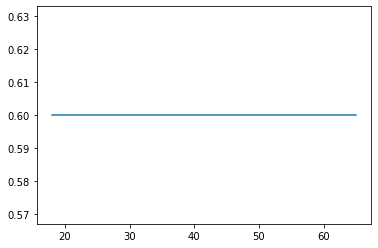

In [34]:
import matplotlib.pyplot as plt
plt.plot(ages, scores)

In [189]:
col_name = "HR"
col_v = range(50,150)
scores = []
for v in tqdm(col_v):
    score = compute_score(0, 40, v, 1, col_name, models_dir)
    scores.append(score)

100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


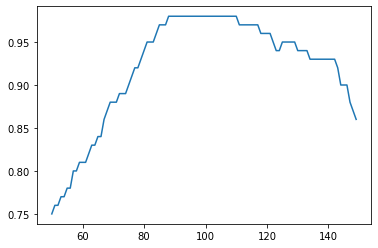

In [191]:
plt.plot(col_v, scores)

In [69]:
ages = np.linspace(18,65, num=65-18 + 1)
hrs = np.linspace(50,150, num=int((150-50)/4 + 1))
df = pd.DataFrame()
for age in tqdm(ages):
    for hr in hrs:
        score = compute_score(0, age, hr, 2, col_name, models_dir)
        df = df.append({'age': age, 'hr': hr, 'score': score}, ignore_index=True)

100%|██████████| 48/48 [04:00<00:00,  5.01s/it]


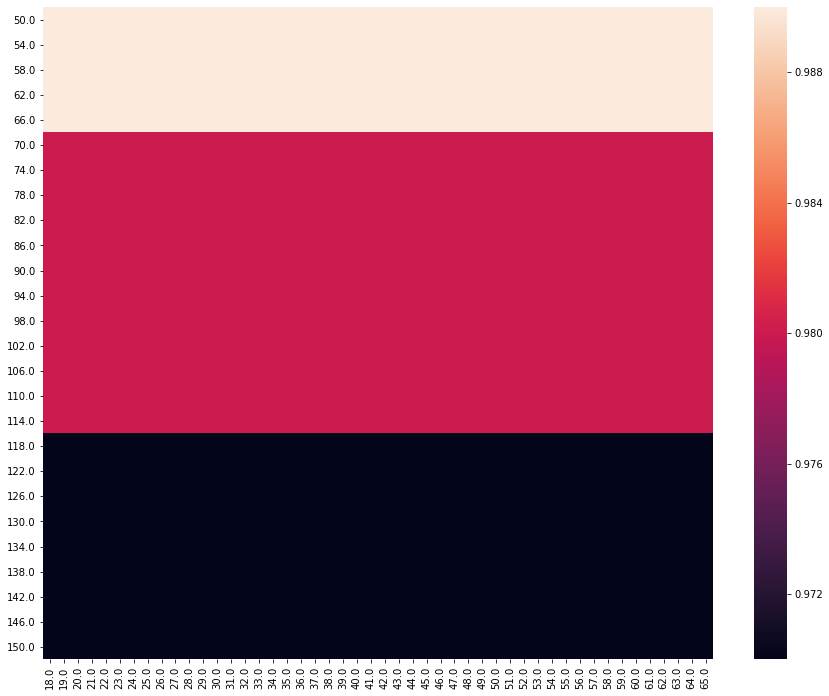

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

fig, axs = plt.subplots(1, 1, figsize=(15,12))
df_pivot = df.pivot_table(index="hr", columns="age", values="score", aggfunc=np.max)
df_pivot_smooth = gaussian_filter(df_pivot, sigma=0.1)

sns.heatmap(df_pivot_smooth, vmax=df_pivot.values.max(), xticklabels=ages, yticklabels=hrs, vmin=df_pivot.values.min(), ax=axs)
plt.show()

# Compute scores on validation data

In [229]:
def compute_score_tensor(gender, age, col_v, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=1)
    gender = gender - 0.5
    action = action.to(torch.long)
    age_normalized_sim = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
    col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
    sim_input = torch.column_stack((gender, age_normalized_sim, col_normalized_sim)).float()
    age_normalized_obs = (age - MIMICtable_filtered_t0['age'].mean())/MIMICtable_filtered_t0['age'].std()
    col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
    obs_input = torch.column_stack((gender, age_normalized_obs, col_normalized_obs)).float()
    action_tensor = (action-1)/24
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=3, output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
        policy.eval()
        prob = softmax(policy(obs_input))
        prob = prob[torch.arange(len(prob)), action-1]
        lb = prob*yobs_model(torch.column_stack((obs_input, action_tensor))).squeeze() + (1-prob)*(ymin_model(obs_input)).squeeze()
        ub = prob*yobs_model(torch.column_stack((obs_input, action_tensor))).squeeze() + (1-prob)*(ymax_model(obs_input)).squeeze()
        sim = ysim_model(torch.column_stack((sim_input, action_tensor))).squeeze()
        p += ((lb<=sim)&(sim<=ub)).float()
    p = p/nr_reps
    return p.numpy() 

In [31]:
def compute_score_tensor_updated(obs_input, sim_input, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=1)
    action_tensor = (action-1)/24
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=obs_input.shape[1]+1, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/yobs_{col_name}_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=obs_input.shape[1], n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/ymax_{col_name}_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=obs_input.shape[1], n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/ymin_{col_name}_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=sim_input.shape[1] + 1, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/ysim_{col_name}_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=obs_input.shape[1], output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/policy_0'))
        policy.eval()
        prob = softmax(policy(obs_input))
        prob = prob[torch.arange(len(prob)), action-1]
        lb = prob*yobs_model(torch.column_stack((obs_input, action_tensor))).squeeze() + (1-prob)*(ymin_model(obs_input)).squeeze()
        ub = prob*yobs_model(torch.column_stack((obs_input, action_tensor))).squeeze() + (1-prob)*(ymax_model(obs_input)).squeeze()
        sim = ysim_model(torch.column_stack((sim_input, action_tensor))).squeeze()
        p += ((lb<=sim)&(sim<=ub)).float()
    p = p/nr_reps
    return p.numpy() 

In [17]:
MIMICtable_val = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-test.csv")
MIMICtable_val['icustay_id'] = MIMICtable_val['icustay_id'].astype(int)
MIMICtable_val.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,32796,4.882446e+09,1.0,30118.703299,5.0,1.0,0.0,0.0,0.0,...,0.0,0.767176,867.592593,0.0,0.0,1753.737817,20.020,2390.0,1195.0,-616.242183
1,2,32796,4.882450e+09,1.0,30118.703299,5.0,1.0,0.0,0.0,0.0,...,0.0,0.762025,348.333333,0.0,0.0,1773.757817,20.020,3540.0,1150.0,-1746.222183
2,3,32796,4.882453e+09,1.0,30118.703299,5.0,1.0,0.0,0.0,0.0,...,0.0,0.688000,1261.111111,0.0,0.0,1793.777817,20.020,4690.0,1150.0,-2876.202183
3,4,32796,4.882457e+09,1.0,30118.703299,5.0,1.0,0.0,0.0,0.0,...,0.0,0.671875,213.888889,0.0,0.0,1813.797817,20.020,5840.0,1150.0,-4006.182183
4,5,32796,4.882460e+09,1.0,30118.703299,5.0,1.0,0.0,0.0,0.0,...,0.0,0.700000,175.000000,0.0,0.0,1833.817817,18.349,6910.0,1070.0,-5057.833183


In [18]:
def get_vaso_bin(vaso):
    for v in range(1, 6):
        if (vaso <= MIMICtable_filtered_t0.loc[vc==v, 'max_dose_vaso'].max()) and (vaso >= MIMICtable_filtered_t0.loc[vc==v, 'max_dose_vaso'].min()):
            return v

def get_iv_bin(iv_vol):
    for iv in range(1, 6):
        if (iv_vol <= MIMICtable_filtered_t0.loc[io==iv, 'input_1hourly'].max()) and (iv_vol >= MIMICtable_filtered_t0.loc[io==iv, 'input_1hourly'].min()):
            return iv

def get_action_bin(iv, vaso):
    for index, row in uniqueValues.iterrows():
        if (row['IV']==iv) and (row['VC']==vaso):
            return index+1
            

In [19]:
for index, row in MIMICtable_val.iterrows():
    vaso = get_vaso_bin(row['max_dose_vaso'])
    iv = get_iv_bin(row['input_1hourly'])
    MIMICtable_val.loc[index, 'A'] = get_action_bin(iv, vaso)

In [20]:
MIMICtable_val_t0 = MIMICtable_val[MIMICtable_val['bloc']==1]
MIMICtable_val_t0 = MIMICtable_val_t0[MIMICtable_val_t0['A'].between(1,25)]

In [24]:
cols = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']

colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

x_columns = ['gender', 'age', 'Weight_kg'] + cols
MIMICvalraw = MIMICtable_val_t0[x_columns].copy()

for col in MIMICvalraw:
    if col in colbin:
        MIMICvalraw[col] = MIMICvalraw[col] - 0.5
    elif col in colnorm:
        cmu = MIMICtable_filtered_t0[col].mean()
        csigma = MIMICtable_filtered_t0[col].std()
        MIMICvalraw[col] = (MIMICvalraw[col] - cmu)/csigma
    elif col in collog:
        log_values = np.log(0.1 + MIMICvalraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma 
        
obs_input = torch.FloatTensor(MIMICvalraw.values)

In [27]:
pulsevalraw = MIMICtable_val_t0[x_columns].copy()
mimic_cols = ['age','Weight_kg']

for col in pulsevalraw:
    if col in colbin:
        pulsevalraw[col] = pulsevalraw[col] - 0.5
    elif col in mimic_cols:
        cmu = MIMICtable_filtered_t0[col].mean()
        csigma = MIMICtable_filtered_t0[col].std()
        pulsevalraw[col] = (pulsevalraw[col] - cmu)/csigma
    elif col in colnorm:
        cmu = pulse_data_t0[col].mean()
        csigma = pulse_data_t1[col].std()
        pulsevalraw[col] = (pulsevalraw[col] - cmu)/csigma
    elif col in collog:
        log_values = np.log(0.1 + pulsevalraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        pulsevalraw[col] = (log_values - dmu)/dsigma
        
sim_input = torch.FloatTensor(pulsevalraw.values)

In [32]:
# compute_score_tensor_updated(obs_input, sim_input, action, col_name, models_dir)
scores = pd.DataFrame()
for col_name in tqdm(cols):
    a = torch.FloatTensor(MIMICtable_val_t0['A'].values).to(torch.long)
    score = compute_score_tensor_updated(obs_input, sim_input, a, col_name, models_dir)              
    scoresdf = MIMICtable_val_t0.copy()
    scoresdf['col'] = col_name
    scoresdf['Scores'] = score
    scores = scores.append(scoresdf, ignore_index=True)

100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


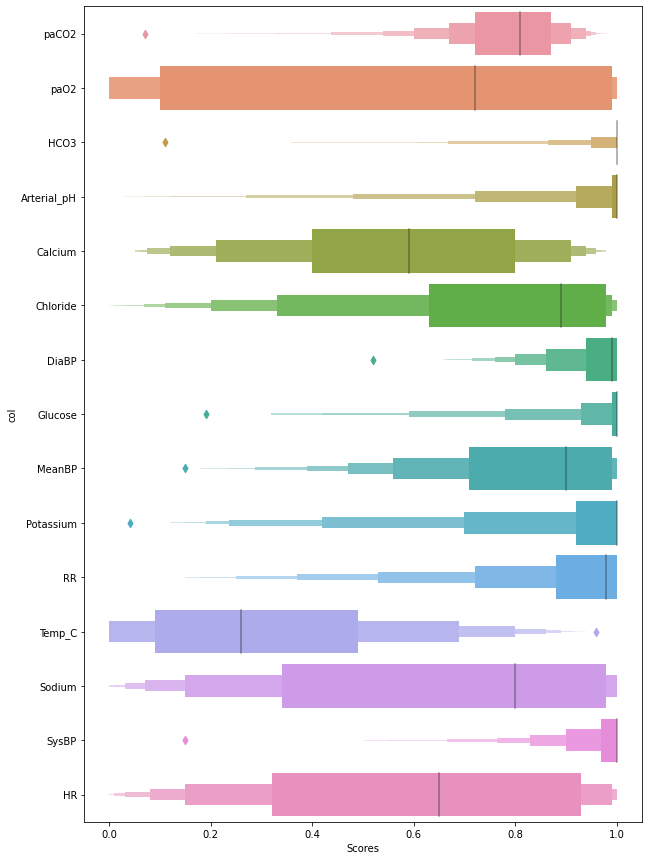

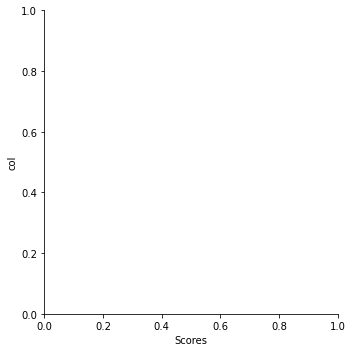

In [33]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(10,15))
sns.catplot(x='Scores',y='col', data=scores, ax=axs, kind="boxen")